In [ ]:
# default_exp data.manipulate

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import os
import numpy as np
import pandas as pd
import pydicom

# Intelligent Imaging Data Dongle

> Suite of python tools for handling medical data.

## DataLoader

In [ ]:
#export
def dcm2array(path_to_dicom_dir, sort_by_slice_location=True):
    """
    
    Parameters
    ----------
    path_to_dicom_dir : str
        path to folder containing all dicom files for *one patient*
    sort_by_slice_location : bool
        if True, returning array will be ordered by slice location

    Returns
    -------
    pixel_array : arr
        3D array containing pixel data from dicom files
        
    Notes
    -------
    This function will initially try to read the pixel data directly
    using pydicom.dcmread. If this fails, it will then attempt to 
    decompress the data and then read the jpeg files. 
    
    """
    
    df = pd.DataFrame()
    df['filename']= os.listdir(path_to_dicom_dir)
    df['pathname']= path_to_dicom_dir + df['filename']

    try:
        df['DS']=[pydicom.dcmread(x) for x in df['pathname']]
        df['SOPInstanceUID'] = [x.SOPInstanceUID for x in df['DS']]
        df['SliceLoc'] = [x.InstanceNumber for x in df['DS']]
        df['Pixels'] = [x.pixel_array for x in df['DS']]
        tempo = df['DS'][0]
        im_at = tempo.AcquisitionMatrix, tempo.PixelSpacing
    except:
        print('Traditional dcm reading did not working.')
        print('Attempting to read uncompressed data')
        print('Making temporary directory')
        temp_dir = './dcm2array_tmpdir/'

        #create temp dirs
        os.mkdir(temp_dir)

        df['tempfname'] = temp_dir + df['filename']

        FNULL = open(os.devnull, 'w')
        [subprocess.run('dcmdjpeg -v {} {}'.format(x[1], df['tempfname'][x[0]]), shell=True, stdout=FNULL, stderr=subprocess.STDOUT) for x in enumerate(df['pathname'])]

        df['DS']=[pydicom.dcmread(x) for x in df['tempfname']]
        df['SOPInstanceUID'] = [x.SOPInstanceUID for x in df['DS']]
        df['SliceLoc'] = [x.InstanceNumber for x in df['DS']]
        df['Pixels'] = [x.pixel_array for x in df['DS']]
        tempo = df['DS'][0]
        im_at = tempo.AcquisitionMatrix, tempo.PixelSpacing   
        #get rid of temp dirs
        [os.remove(x) for x in df['tempfname']]

    if sort_by_slice_location == True:
        df = df.sort_values(by=['SliceLoc'])
    pixel_array = np.dstack(np.asarray(df['Pixels']))

    return pixel_array

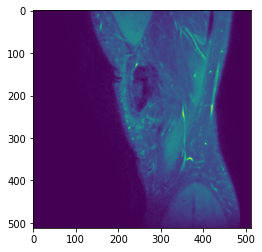

In [ ]:
# example usage:
import matplotlib.pyplot as plt
data_path = '../../../3_data/GE/Exam3038_Series5/'
array = dcm2array(path_to_dicom_dir = data_path, sort_by_slice_location=True)
plt.imshow(array[:,:,0])
plt.show()